## Barrier Option Pricing
### We work within the framework of the Black & Scholes model. Reference values can be taken as S0​=100, K=100, T=1, r=0.05, σ=0.20, d=12, B=140, L=95, N=104 to 105.

In [ ]:
# Monte Carlo : Discrete Barrier
def mc_up_out_discrete(S0, K, T, r, sigma, B, d, N):
    dt = T / d
    # Simulation of complete trajectories over d steps
    Z = np.random.randn(N, d)
    growth_factors = np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
    paths = S0 * np.cumprod(growth_factors, axis=1)

    # Barrier check
    barrier_crossed = np.max(paths, axis=1) >= B

    # Payoff (vectorized)
    ST = paths[:, -1]
    payoffs = np.where(barrier_crossed, 0, np.maximum(ST - K, 0))

    price = np.exp(-r * T) * np.mean(payoffs)
    std_err = np.exp(-r * T) * np.std(payoffs) / np.sqrt(N)
    return price, 1.96 * std_err

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

### 1. We plot the price (with confidence interval) of the Up-and-Out Call option with barrier level B as a function of S0 (comparing it with the standard call). We also add the Monte Carlo price (with confidence interval) of the continuous variant.

$H = (S_T - K)_{+}*1_{(Max(S_{T_i})_{i \in [0,n]}<M)}$

In [ ]:
# Parameters
S0_ref = 100
K = 100
T = 1.0
r = 0.05
sigma = 0.20
d = 12
B = 140
N = 50000  # Number of simulations

# Standard Black-Scholes Formula (European Call Reference)
def bs_call_price(S, K, T, r, sigma):
    if T <= 0: return np.maximum(S - K, 0)
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

#### **Monte Carlo: Discrete Barrier**
To move from a date ti−1​ to ti​, we use the fundamental property of the Black-Scholes model: the price follows a geometric Brownian motion.

We generate the next price using the formula:
$$Sti​​=Sti−1​∗​exp((r−2σ2​)Δt+σΔt​Zi​)$$

where Zi​ is a standard normal random variable.


At the end, over the entire simulated path, we check if any of the prices Sti​​ has exceeded the barrier B.

- If max(St1​​,...,Std​​)≥B, the option is deactivated ("knock-out") and is worth 0.

- Otherwise, the option survives and pays (ST​−K)+​ at the end.

In [ ]:
# Monte Carlo : Barrière Discrète
def mc_up_out_discrete(S0, K, T, r, sigma, B, d, N):
    dt = T / d
    # Simulation des trajectoires complètes sur d pas
    Z = np.random.randn(N, d)
    growth_factors = np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
    paths = S0 * np.cumprod(growth_factors, axis=1)

    # Vérification de la barrière
    barrier_crossed = np.max(paths, axis=1) >= B

    # Payoff (vectorisé)
    ST = paths[:, -1]
    payoffs = np.where(barrier_crossed, 0, np.maximum(ST - K, 0))

    price = np.exp(-r * T) * np.mean(payoffs)
    std_err = np.exp(-r * T) * np.std(payoffs) / np.sqrt(N)
    return price, 1.96 * std_err

#### **Monte Carlo: Continuous Barrier**

$M_T^X= \frac{X_​+ \sqrt{X_T^2​−2Tln(U)}}{2}$​​

with U being a uniform random variable on [0,1]

Then,
$ Max(ST​​)=S0​∗​exp(σMTX​) $​

- If this theoretical maximum exceeds B, the option is deactivated and is worth 0.

- Otherwise, it pays $(ST​​−K)+$​.

In [ ]:
# Monte Carlo : Continuous Barrier
def mc_up_out_continuous(S0, K, T, r, sigma, B, N):
    # Simulation of the final point S_T only
    Z = np.random.randn(N)
    ST = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)

    # Simulation of the conditional maximum M_T^X given X_T
    U = np.random.rand(N)
    XT = np.log(ST / S0) / sigma

     # Symmetric formula for the maximum
    Max_XT = (XT + np.sqrt(XT**2 - 2 * T * np.log(U))) / 2
    Max_ST = S0 * np.exp(sigma * Max_XT) # Back to price

    # Barrier Check
    payoffs = np.where(Max_ST >= B, 0, np.maximum(ST - K, 0))

    # Payoff (vectorized)
    price = np.exp(-r * T) * np.mean(payoffs)
    std_err = np.exp(-r * T) * np.std(payoffs) / np.sqrt(N)
    return price, 1.96 * std_err

Calculations in progress for 30 S0 values...


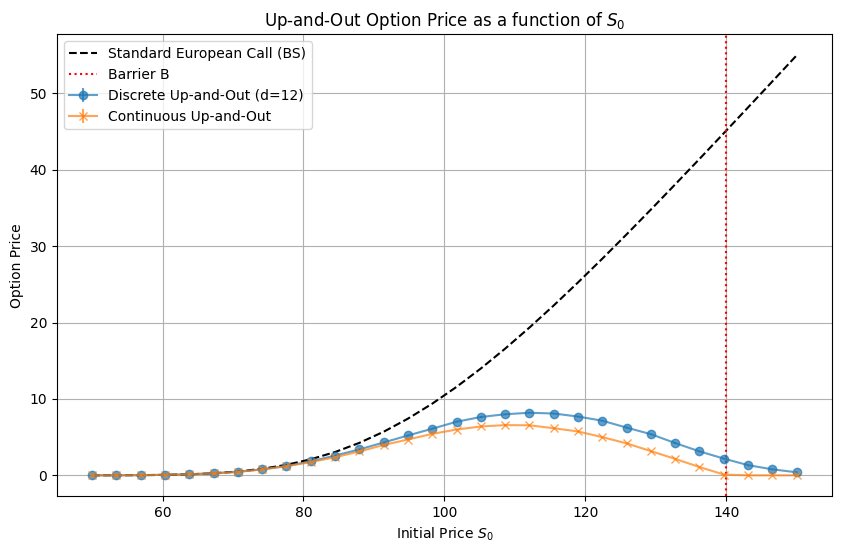

In [ ]:
# Execution for different S0
S0_range = np.linspace(50, 150, 30)
prices_discrete = []
cis_discrete = []
prices_continuous = []
cis_continuous = []
prices_bs = []

print(f"Calculations in progress for {len(S0_range)} S0 values...")

for S in S0_range:
    # Standard BS
    prices_bs.append(bs_call_price(S, K, T, r, sigma))

    # Discrete
    p_d, ci_d = mc_up_out_discrete(S, K, T, r, sigma, B, d, N)
    prices_discrete.append(p_d)
    cis_discrete.append(ci_d)

    # Continuous
    p_c, ci_c = mc_up_out_continuous(S, K, T, r, sigma, B, N)
    prices_continuous.append(p_c)
    cis_continuous.append(ci_c)

# Plot
plt.figure(figsize=(10, 6))

# Standard Call
plt.plot(S0_range, prices_bs, 'k--', label='Standard European Call (BS)')

# Discrete Barrier
plt.errorbar(S0_range, prices_discrete, yerr=cis_discrete, fmt='o-', label=f'Discrete Up-and-Out (d={d})', alpha=0.7)

# Continuous Barrier
plt.errorbar(S0_range, prices_continuous, yerr=cis_continuous, fmt='x-', label='Continuous Up-and-Out', alpha=0.7)

# Vertical line for the barrier
plt.axvline(B, color='r', linestyle=':', label='Barrier B')

plt.title("Up-and-Out Option Price as a function of $S_0$")
plt.xlabel("Initial Price $S_0$")
plt.ylabel("Option Price")
plt.legend()
plt.grid(True)
plt.show()

Unlike the vanilla option price which increases as S0 increases, the Up-and-Out option payoff forms a bell curve (the price becomes low when approaching the barrier). Note that the continuous Up-and-Out option price is zero when S0 equals the barrier because S0=B => H=0, but this is not the case for the discrete option which does not always trigger the barrier if i does not take 0 as a value.

As d increases, the discrete option payoff will converge towards the continuous option payoff.

### 2. We plot the Monte Carlo price (with confidence interval) of the Up-and-Out barrier call option (discrete variant) as a function of the number of observation dates. Then, we add the Monte Carlo price (with confidence interval) of the continuous variant.


Calculations in progress for different values of d...
d =   1 | Discrete Price = 7.3407 +/- 0.0897
d =   6 | Discrete Price = 6.7502 +/- 0.0860
d =  12 | Discrete Price = 6.6278 +/- 0.0843
d =  24 | Discrete Price = 6.3051 +/- 0.0818
d =  52 | Discrete Price = 6.1657 +/- 0.0806
d = 100 | Discrete Price = 6.0929 +/- 0.0800
d = 200 | Discrete Price = 5.9048 +/- 0.0784
d = 365 | Discrete Price = 5.9116 +/- 0.0784
d = 500 | Discrete Price = 5.8608 +/- 0.0779
       | Continuous Price = 5.6803 +/- 0.0764


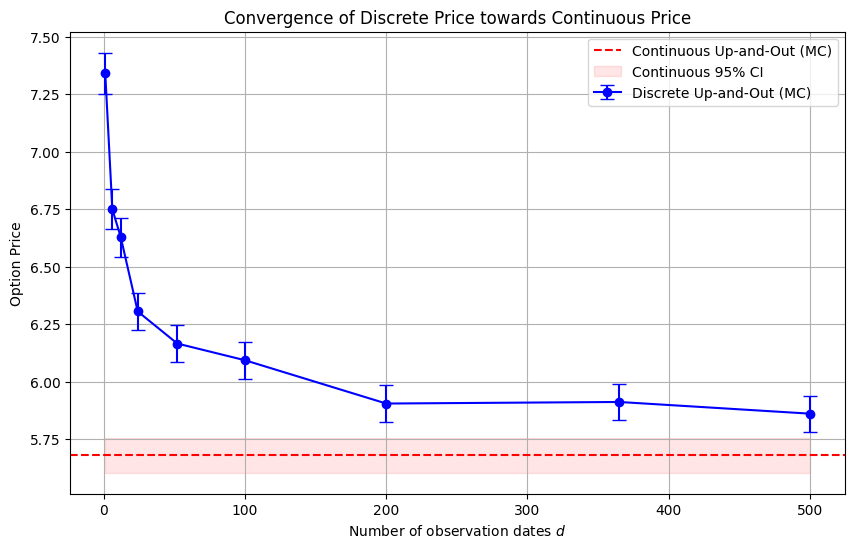

In [ ]:
# List of d values to test (from monthly to quasi-daily)
d_values = [1, 6, 12, 24, 52, 100, 200, 365, 500]

discrete_prices = []
discrete_cis = []

print("Calculations in progress for different values of d...")

# Calculate discrete prices
for d in d_values:
    price, ci = mc_up_out_discrete(S0_ref, K, T, r, sigma, B, d, N)
    discrete_prices.append(price)
    discrete_cis.append(ci)
    print(f"d = {d:3d} | Discrete Price = {price:.4f} +/- {ci:.4f}")

# Calculate continuous price
cont_price, cont_ci = mc_up_out_continuous(S0_ref, K, T, r, sigma, B, N)
print(f"       | Continuous Price = {cont_price:.4f} +/- {cont_ci:.4f}")

# Plot
plt.figure(figsize=(10, 6))

# Discrete curve with CI
plt.errorbar(d_values, discrete_prices, yerr=discrete_cis, fmt='-o',
             capsize=5, label="Discrete Up-and-Out (MC)", color='blue')

# Reference line for Continuous (with its MC uncertainty zone)
plt.axhline(cont_price, color='red', linestyle='--', label="Continuous Up-and-Out (MC)")
plt.fill_between(d_values, cont_price - cont_ci, cont_price + cont_ci,
                 color='red', alpha=0.1, label="Continuous 95% CI")

plt.title("Convergence of Discrete Price towards Continuous Price")
plt.xlabel("Number of observation dates $d$")
plt.ylabel("Option Price")
plt.legend()
plt.grid(True)
plt.show()

The discrete Up-and-Out call price converges towards the continuous Up-and-Out call price as d tends to infinity.

### 3. We repeat 1. formula for a Down-and-In call of level L.

$H = (S_T - K)_{+}*1_{(Min(S_{T_i})_{i \in [0,n]}<=L)}$ (Option with lower activating barrier)

In [ ]:
L = 95  # Lower barrier (activating)

In [ ]:
# Monte Carlo : Discrete Down-and-In
def mc_down_in_discrete(S0, K, T, r, sigma, L, d, N):
    dt = T / d
    Z = np.random.randn(N, d)
    growth = np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
    paths = S0 * np.cumprod(growth, axis=1)

    # Activation condition: the minimum touches L
    barrier_hit = np.min(paths, axis=1) <= L

    ST = paths[:, -1]
    # Payoff: Standard Call IF barrier hit, otherwise 0
    payoffs = np.where(barrier_hit, np.maximum(ST - K, 0), 0)

    price = np.exp(-r * T) * np.mean(payoffs)
    std = np.exp(-r * T) * np.std(payoffs)
    return price, 1.96 * std / np.sqrt(N)

In [ ]:
# Monte Carlo : Continuous Down-and-In
def mc_down_in_continuous(S0, K, T, r, sigma, L, N):
    # Simulation of the final point S_T
    Z = np.random.randn(N)
    ST = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)

    # Simulation of the conditional minimum m_T
    U = np.random.rand(N)
    XT = np.log(ST / S0) / sigma

    # Symmetric formula for the minimum
    min_XT = (XT - np.sqrt(XT**2 - 2 * T * np.log(U))) / 2 # there is a "-" before the square root this time.
    min_ST = S0 * np.exp(sigma * min_XT)

    # Activation condition
    barrier_hit = min_ST <=  L

    payoffs = np.where(barrier_hit, np.maximum(ST - K, 0), 0)

    price = np.exp(-r * T) * np.mean(payoffs)
    std = np.exp(-r * T) * np.std(payoffs)
    return price, 1.96 * std / np.sqrt(N)

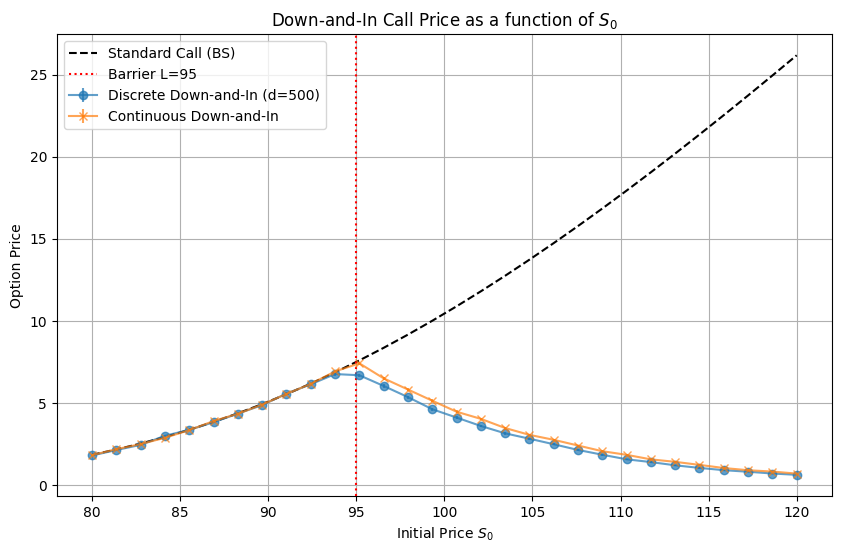

In [ ]:
# Comparison as a function of S0
S0_list = np.linspace(80, 120, 30)
res_discrete, res_continuous, res_bs = [], [], []
ci_discrete, ci_continuous = [], []

np.random.seed(42)

for S in S0_list:
    # BS
    res_bs.append(bs_call_price(S, K, T, r, sigma))

    # Discrete
    p_d, ci_d = mc_down_in_discrete(S, K, T, r, sigma, L, d, N)
    res_discrete.append(p_d)
    ci_discrete.append(ci_d)

    # Continuous
    p_c, ci_c = mc_down_in_continuous(S, K, T, r, sigma, L, N)
    res_continuous.append(p_c)
    ci_continuous.append(ci_c)

# --- Plot ---
plt.figure(figsize=(10, 6))
plt.plot(S0_list, res_bs, 'k--', label='Standard Call (BS)')
plt.errorbar(S0_list, res_discrete, yerr=ci_discrete, fmt='o-', label=f'Discrete Down-and-In (d={d})', alpha=0.7)
plt.errorbar(S0_list, res_continuous, yerr=ci_continuous, fmt='x-', label='Continuous Down-and-In', alpha=0.7)

plt.axvline(L, color='r', linestyle=':', label='Barrier L=95')
plt.title("Down-and-In Call Price as a function of $S_0$")
plt.xlabel("Initial Price $S_0$")
plt.ylabel("Option Price")
plt.legend()
plt.grid(True)
plt.show()

Unlike the vanilla option price which increases as S0 increases, the Down-and-In option payoff forms a peak (the price becomes maximal when the barrier is reached). The price of this option is 0 when S0 moves away from the barrier B.

As d increases, the discrete option payoff will converge towards the continuous option payoff.

### 4. We implement a conditional Monte Carlo for the Down-and-In call pricing (i.e., using the information available at the barrier crossing). We then find the variance reduction factor obtained, and compare it with a reduction by antithetic variables.

We condition on the barrier activation event given $S_T​$, i.e.  $\min_{0 \le t \le T} S_t \le L$ given $S_T$.

At the moment the barrier is activated, the option price becomes a standard European Call with strike K, maturity T−τ, and initial price Sτ​ ≈ B. Therefore, we replace the random payoff (ST​−K)+​ with its exact expected value given by the Black-Scholes formula: CBS​(Sτ​,K,T−τ). If the barrier is never touched, the payoff is 0.

This method removes all variance related to the price evolution after crossing the barrier.

The conditional estimator is given by:

$$
C_{cond} =\mathbb{E}\left[ e^{-rT}(S_T - K)_+ | \min_{0 \le t \le T} S_t \le L \mid S_T\right] = e^{-rT} \mathbb{E}\left[ (S_T - K)_+ \right] \cdot \mathbb{P}\left(\min_{0 \le t \le T} S_t \le L \mid S_T\right)
$$

The conditional probability of hitting the barrier L given the arrival point ST​ is given by the reflection principle:

$$
\mathbb{P}\left(\min_{0 \le t \le T} S_t \le L \mid S_T\right) = F_{m_T|S_T}(L) =
\begin{cases}
1 & \text{si } S_T \le L \\
\exp\left( -\frac{2 \ln(S_0/L) \ln(S_T/L)}{\sigma^2 T} \right) & \text{si } S_T > L
\end{cases}
$$



In [ ]:
# 1. Conditional Method
def mc_down_in_continuous_conditional(S0, K, T, r, sigma, L, N):
    # We simulate S_T
    Z = np.random.randn(N)
    ST = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)

    # Calculate the probability of hitting the barrier given S_T
    prob_hit = np.ones(N)
    mask_above = ST > L

    arg = -2 * np.log(S0 / L) * np.log(ST[mask_above] / L) / (sigma**2 * T)
    prob_hit[mask_above] = np.exp(arg)

    # Smoothed Payoff: (ST - K)+ * Prob
    payoffs = np.maximum(ST - K, 0) * prob_hit

    return np.exp(-r * T) * np.mean(payoffs), np.exp(-r * T) * np.var(payoffs)

# 2. Antithetic Variables (For comparison)
def mc_down_in_continuous_antithetic(S0, K, T, r, sigma, L, N_pairs):
    # Pairs (Z, -Z)
    Z = np.random.randn(N_pairs)

    # Local function to calculate the payoff of a vector Z
    def compute_payoff(Z_vec):
        ST = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z_vec)
        XT = np.log(ST / S0) / sigma
        U = np.random.rand(len(Z_vec))
        Min_XT = (XT - np.sqrt(XT**2 - 2 * T * np.log(U))) / 2
        Min_ST = S0 * np.exp(sigma * Min_XT)
        return np.where(Min_ST <= L, np.maximum(ST - K, 0), 0)

    p1 = compute_payoff(Z)
    p2 = compute_payoff(-Z)

    # Average estimator per pair
    Y = 0.5 * (p1 + p2)

    return np.exp(-r * T) * np.mean(Y), np.exp(-r * T) * np.var(Y)


Reduction Factor (Conditional Method):

$$
\text{Facteur}_{cond} = \frac{\text{Var}(Y_{standard})}{\text{Var}(Y_{cond})}
$$

Reduction Factor (Antithetic Variables):

$$
\text{Facteur}_{anti} = \frac{\text{Var}(Y_{standard})}{2 \text{Cov}(Y, Y')} = \frac{1}{1 + \rho}
$$

Where ρ is the correlation between the payoff generated by the path $Z$ and the one generated by $−Z$.


In [ ]:
# Execution:

# Standard
price_std, var_std = mc_down_in_continuous(S0_ref, K, T, r, sigma, L, N)

# Conditional
price_cond, var_cond = mc_down_in_continuous_conditional(S0_ref, K, T, r, sigma, L, N)

# Antithetic (N/2 pairs for iso-budget simulation comparison)
price_anti, var_anti_pair = mc_down_in_continuous_antithetic(S0_ref, K, T, r, sigma, L, N // 2)

# Reduction Factors
# For antithetic, we compare the variance of the final estimator
factor_cond = var_std / var_cond
factor_anti = var_std / (2 * var_anti_pair)

print(f"Standard Price      : {price_std:.4f} (Var: {var_std:.4f})")
print(f"Conditional Price  : {price_cond:.4f} (Var: {var_cond:.4f})")
print(f"Antithetic Price  : {price_anti:.4f}")
print("-" * 30)
print(f"Variance Reduction (Conditional) : x {factor_cond:.2f}")
print(f"Variance Reduction (Antithetic) : x {factor_anti:.2f}")

Standard Price      : 4.7771 (Var: 0.0873)
Conditional Price  : 4.8189 (Var: 30.1545)
Antithetic Price  : 4.8532
------------------------------
Variance Reduction (Conditional) : x 0.00
Variance Reduction (Antithetic) : x 0.00


Thanks to the Conditional method, we reduce the variance 3 times more than by using the antithetic method.